# Задача III.5.12
##### Северилов Павел 674 группа

### Задание
Согласно переписи население США менялось следующим образом:

1910 – 92 228 496 человек,  
1920 – 106 021 537,  
1930 – 123 202 624,  
1940 – 132 164 569,  
1950 – 151 325 798,  
1960 – 179 323 175,  
1970 – 203 211 926,  
1980 – 226 545 805,  
1990 – 248 709 873,  
2000 – 281 421 906. 

Используя многочлены степеней N = 2, 3, 4, 5, построить аппроксимацию этих данных в смысле МНК. Аппроксимацию можно строить на основе базисных многочленов следующих видов:
* $f(x) \approx \sum_{n=0}^N c_nx^n$  
* $f(x) \approx \sum_{n=0}^N c_n(x-1910)^n$
* $f(x) \approx \sum_{n=0}^N c_n(x-1955)^n$
* $f(x) \approx \sum_{n=0}^N c_n((x-1955)/45)^n$

Какое представление базисных многочленов является наилучшим?  
Используйте построенные приближения для предсказания численности населения США в 2010 году и сравните с точным результатом в 308
745 538 человек.

### Решение

In [1]:
import math
import numpy as np
import seaborn as sns
import pandas as pd
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
date = [1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000] 
popul = [92228496, 106021537, 123202624, 132164569, 151325798, 179323175, 203211926, 226545805, 248709873, 281421906]

Загрузим еще данных о населении за каждый год с 1900 по 2007 год 

In [3]:
data = pd.read_excel('./popul.xlsx')
years = data['Year']
population = data['Population']
data.head()

,Year,Population
0,1900,76212168
1,1901,77679853
2,1902,79175803
3,1903,80700562
4,1904,82254684


In [4]:
pop_2010 = 308745538
population_2010 = np.concatenate((population, [308745538]))
years_2010 = np.concatenate((years, [2010]))

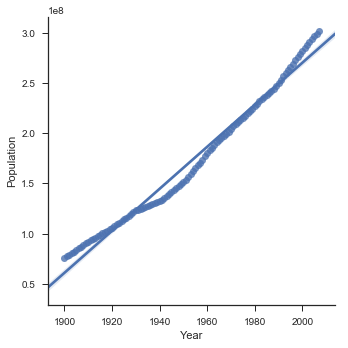

In [5]:
sns.set(style="ticks")
sns.lmplot(x='Year', y='Population', data=data)

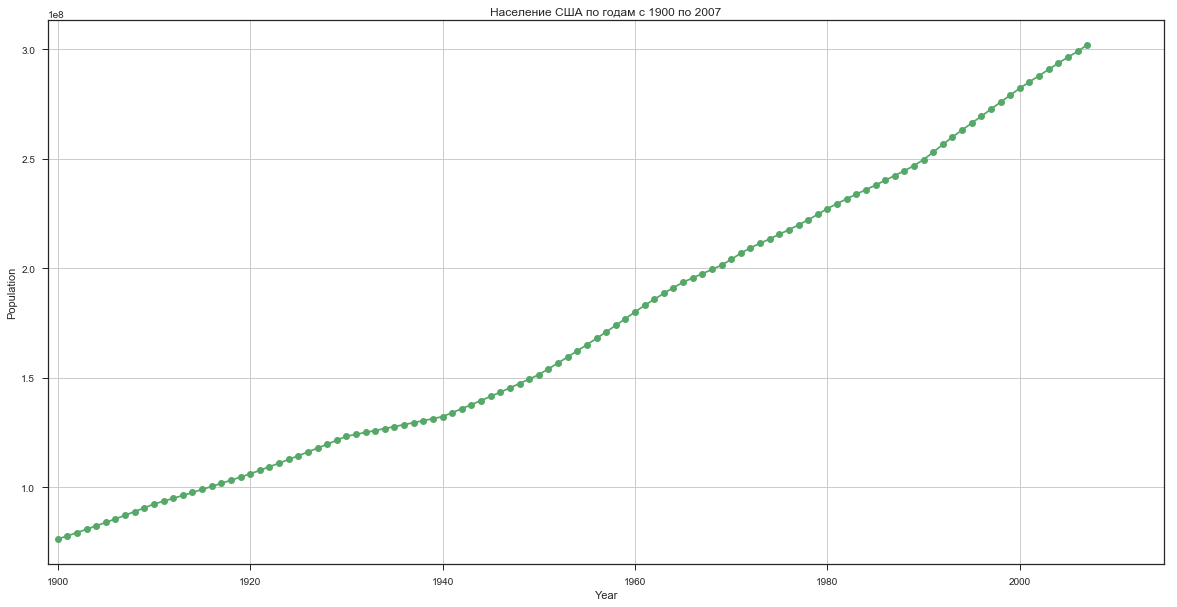

In [6]:
plt.figure(figsize=(20,10))
plt.xlabel('Year')
plt.ylabel('Population')
plt.plot(years, population, '-o', color='C1')
plt.title('Население США по годам с 1900 по 2007')
plt.xlim(1899, 2015)
plt.grid()

### Немного теории перед началом работы

$$S = \sum_{i=1}^N (f(c_i, x_i)-y_i)^2 = |Ac - y|^2\rightarrow min$$ 
$$S = y^Ty - 2y^TAc+c^TA^TAc$$
$$\cfrac{\partial S}{\partial c} = -2A^Ty + 2A^TAc \equiv 0 \Rightarrow \boxed{c = (A^TA)^{-1}(A^Ty)}$$

Где матрица A:
$$A=
\begin{pmatrix}
  1 &x_1 &\dots &x_1^N \\
  \vdots & \vdots & \ddots & \vdots \\
  1 &x_m &\dots &x_m^N
\end{pmatrix}$$

Итоговая аппроксимация будет иметь вид $$f(x)=\sum\limits_{n=0}^N c_n\cdot x^n$$

### Начнем!

Составим функцию, которая вычисляет коэффициенты c, а затем выдает приближенное значение функции f

In [7]:
def test(N):
    A = np.matrix([[x**n for n in range(N+1)] for x in years]) #in np.linspace(0, 1, len(years))
    f = population
    helpA = np.transpose(A) * A
    helpf = np.transpose(A) * np.transpose(np.matrix(f))
    helpInv = np.linalg.inv(helpA) # (A^T*A)^(-1)
    c = np.dot(helpInv, helpf)
    return np.dot(A, c)

Протестируем на значении N = 3

Пунктиром показано приближение функции полученным многочленом

In [8]:
def make_plot():
    plt.figure(figsize=(19,9))
    plt.xlabel('Year', fontsize='xx-large')
    plt.ylabel('Population', fontsize='xx-large')
    plt.xlim(1899, 2015)
    plt.plot(years, population, '-', color='C1') # точные значения населения
    plt.title('Приближение функции населения США многочленами разных типов, $n\in \overline{0,N}$', fontsize='xx-large')
    plt.grid()

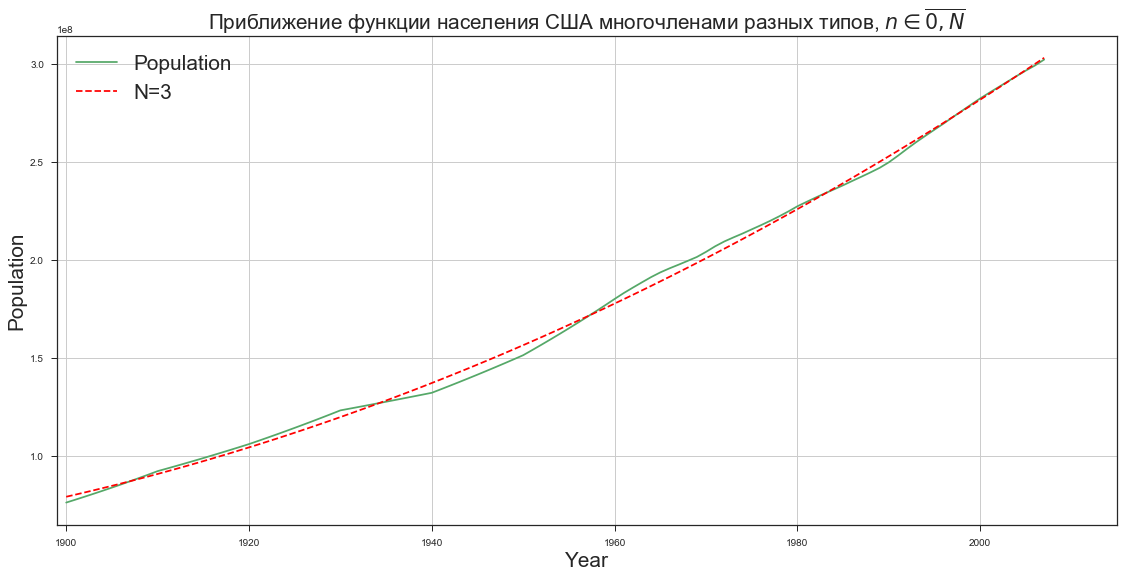

In [9]:
N=3

make_plot()
plt.plot(years, test(N), '--', color='red', label='N='+str(N)) # приближение
plt.legend(loc='best', fontsize='xx-large')

Достаточно неплохо на вид!

Теперь составим подобные функции для остальных типов многочленов, предложенных в задаче, и подберем оптимальные N

a)$~~f(x) \approx \sum_{n=0}^N c_nx^n$  

b)$~~f(x) \approx \sum_{n=0}^N c_n(x-1910)^n$

c)$~~f(x) \approx \sum_{n=0}^N c_n(x-1955)^n$

d)$~~f(x) \approx \sum_{n=0}^N c_n((x-1955)/52)^n$ (так как добавили еще данных до 2007 года, поэтому делим на 52, а не на 45)

e) Свой вариант многочлена: значения x отнормируем: от 0 до 1 с шагом равным 1/108, где 108 -- количество годов в нашей выборке

In [10]:
def approx(N, polynom, plot=False, cond=False):
    
    if polynom == 'a':
        A = np.matrix([[x**n for n in range(N+1)] for x in years])
        A_new = np.matrix([[x**n for n in range(N+1)] for x in years_2010])
    elif polynom == 'b':
        A = np.matrix([[(x-1910)**n for n in range(N+1)] for x in years])
        A_new = np.matrix([[(x-1910)**n for n in range(N+1)] for x in years_2010])
    elif polynom == 'c':
        A = np.matrix([[(x-1955)**n for n in range(N+1)] for x in years])
        A_new = np.matrix([[(x-1955)**n for n in range(N+1)] for x in years_2010])
    elif polynom == 'd':
        A = np.matrix([[((x-1955)/52)**n for n in range(N+1)] for x in years])
        A_new = np.matrix([[((x-1955)/52)**n for n in range(N+1)] for x in years_2010])
    elif polynom == 'e':
        A = np.matrix([[x**n for n in range(N+1)] for x in np.linspace(0, 1, len(years))])
        A_new = np.matrix([[x**n for n in range(N+1)] for x in np.linspace(0, 1, len(years_2010))])
   
    f = population
    helpA = np.transpose(A) * A
    helpf = np.transpose(A) * np.transpose(np.matrix(f))
    helpInv = np.linalg.inv(helpA) # (A^T*A)^(-1)
    c = np.dot(helpInv, helpf)
    f_appr = np.dot(A_new, c) # вместе с 2010 годом
    
    if plot == True:
        plt.plot(years_2010, f_appr, '--', label='N='+str(N)) # приближение
        
    if cond:
        print(np.linalg.cond(helpA)) # число обусловленности A^TA
        
    return f_appr

In [11]:
#for polin in ['a', 'b', 'c', 'd', 'e']:
#    make_plot()
#    for N in range(2, 11):
#        f_appr = approx(N, polin, plot=True)
#        plt.legend(loc='best', fontsize='xx-large')

### Полином a

Для него проверим N от 2 до 5, т.к. после 5 полином очень плохо начинает аппроксимировать. Для подтвреждения приведем случай с N=8

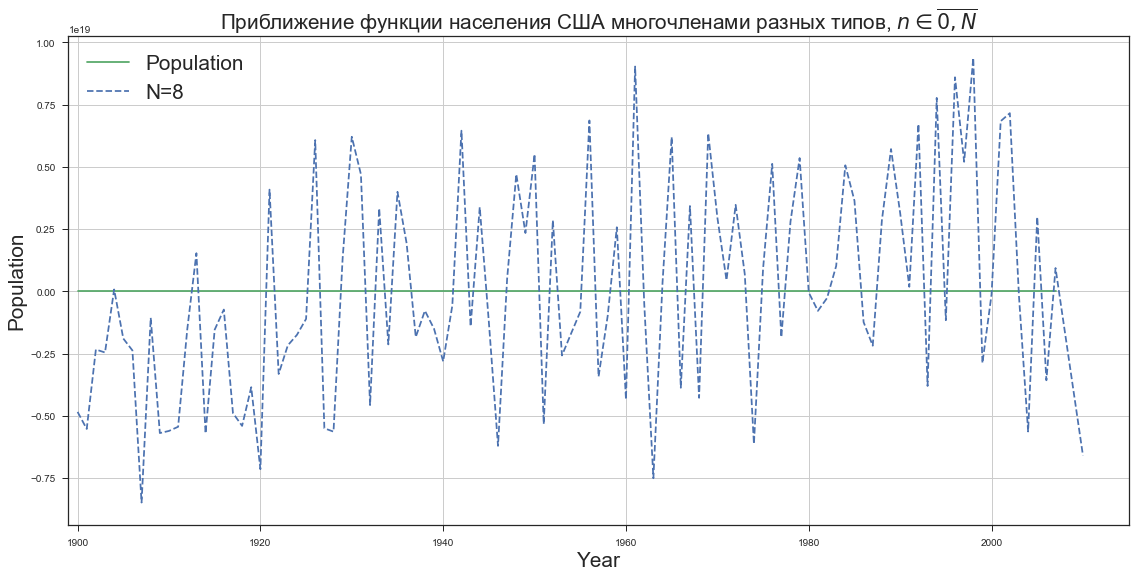

In [12]:
make_plot()
f_appr = approx(8, 'a', plot=True)
plt.legend(loc='best', fontsize='xx-large')

Polynom a
N: 2, MSE: 7245.605059, разница с точным значением в 2010: 3.594628 млн
N: 3, MSE: 7245.920727, разница с точным значением в 2010: 3.596626 млн
N: 4, MSE: 74479.772199, разница с точным значением в 2010: 17.349034 млн
N: 5, MSE: 3305988.697536, разница с точным значением в 2010: 120.382184 млн


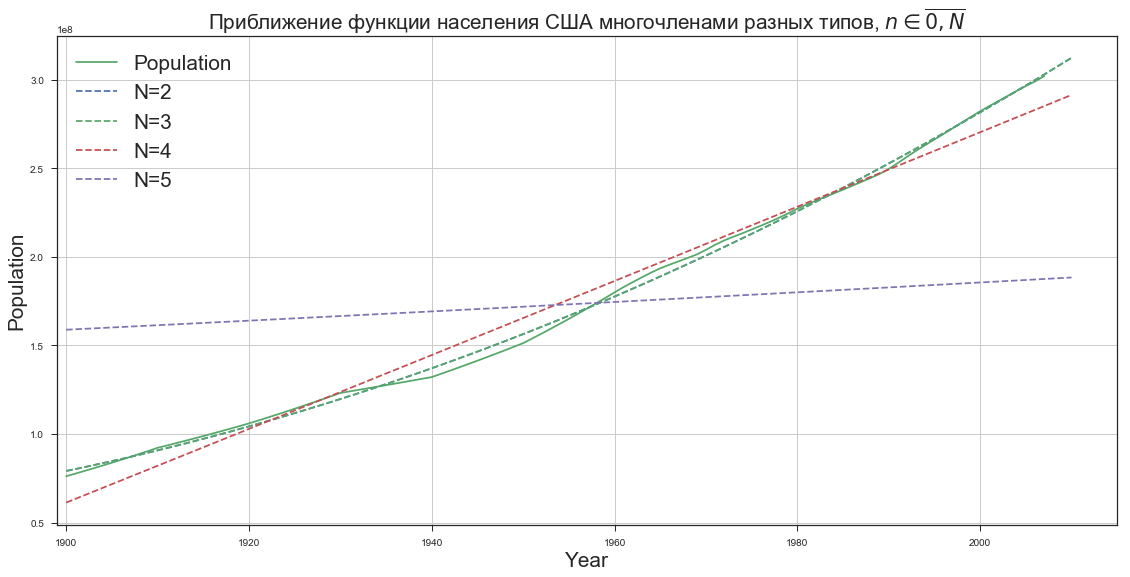

In [13]:
make_plot()
print('Polynom a')
for N in range(2, 6):
    f_appr = approx(N, 'a', plot=True)
    plt.legend(loc='best', fontsize='xx-large')
    print('N: %d, MSE: %f, разница с точным значением в 2010: %f млн' % (N, 
                                        mean_squared_error(population.values, f_appr[:-1])/10**9,
                                        abs(pop_2010 - f_appr[-1:])/10**6))

### Полином b

Polynom b
N: 2, MSE: 7245.605059, разница с точным значением в 2010: 3.594630 млн
N: 3, MSE: 7172.234713, разница с точным значением в 2010: 2.666426 млн
N: 4, MSE: 6415.496031, разница с точным значением в 2010: 1.290168 млн
N: 5, MSE: 4357.555109, разница с точным значением в 2010: 4.437999 млн
N: 6, MSE: 75079.262950, разница с точным значением в 2010: 42.728224 млн


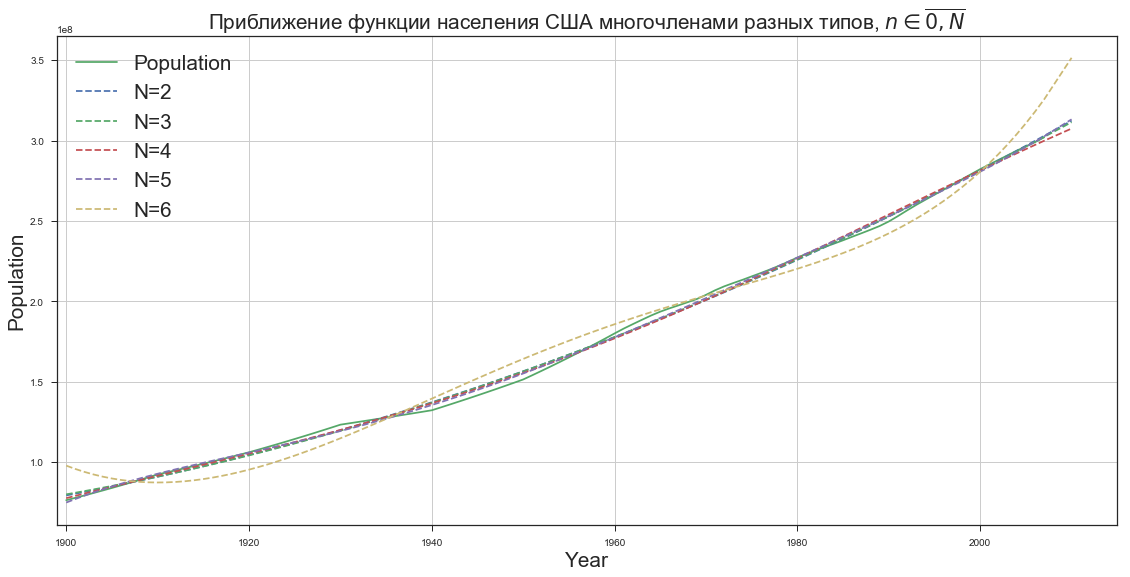

In [14]:
make_plot()
print('Polynom b')
for N in range(2, 7):
    f_appr = approx(N, 'b', plot=True)
    plt.legend(loc='best', fontsize='xx-large')
    print('N: %d, MSE: %f, разница с точным значением в 2010: %f млн' % (N, 
                                        mean_squared_error(population.values, f_appr[:-1])/10**9,
                                        abs(pop_2010 - f_appr[-1:])/10**6))

### Полином c

Polynom c
N: 2, MSE: 7245.605059, разница с точным значением в 2010: 3.594630 млн
N: 3, MSE: 7172.234713, разница с точным значением в 2010: 2.666426 млн
N: 4, MSE: 6415.496031, разница с точным значением в 2010: 1.290168 млн
N: 5, MSE: 3983.745925, разница с точным значением в 2010: 8.132270 млн
N: 6, MSE: 627521.856114, разница с точным значением в 2010: 137.885657 млн


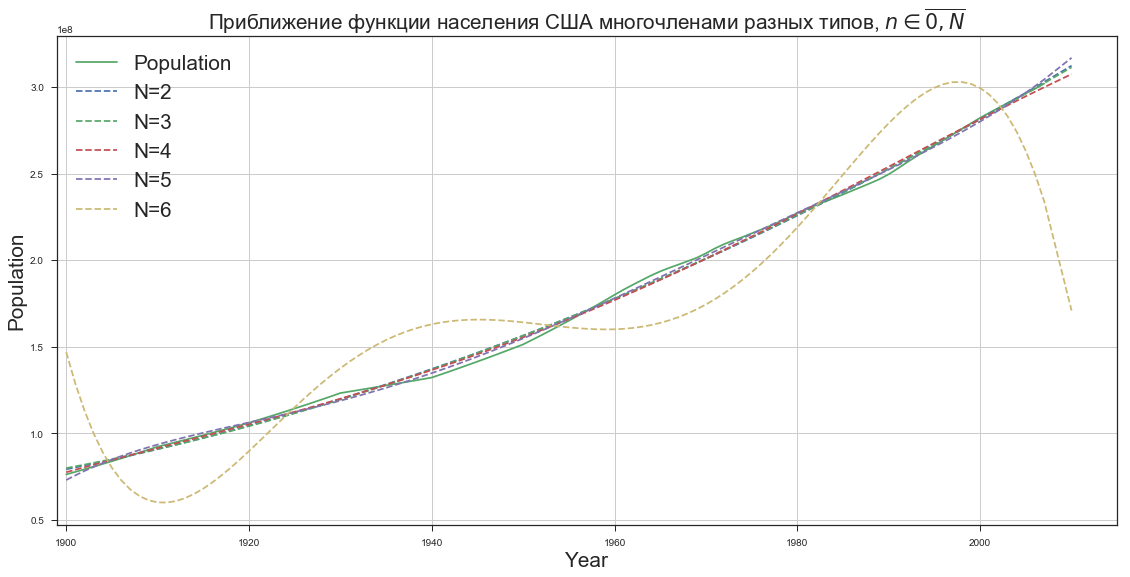

In [15]:
make_plot()
print('Polynom c')
for N in range(2, 7):
    f_appr = approx(N, 'c', plot=True)
    plt.legend(loc='best', fontsize='xx-large')
    print('N: %d, MSE: %f, разница с точным значением в 2010: %f млн' % (N, 
                                        mean_squared_error(population.values, f_appr[:-1])/10**9,
                                        abs(pop_2010 - f_appr[-1:])/10**6))

### Полином d

Polynom d
N: 2, MSE: 7245.605059, разница с точным значением в 2010: 3.594630 млн
N: 3, MSE: 7172.234713, разница с точным значением в 2010: 2.666426 млн
N: 4, MSE: 6415.496031, разница с точным значением в 2010: 1.290168 млн
N: 5, MSE: 3983.745925, разница с точным значением в 2010: 8.132270 млн
N: 6, MSE: 3635.390239, разница с точным значением в 2010: 12.890695 млн
N: 7, MSE: 1653.563331, разница с точным значением в 2010: 2.329995 млн
N: 8, MSE: 1044.714604, разница с точным значением в 2010: 13.699270 млн
N: 9, MSE: 567.719739, разница с точным значением в 2010: 0.076044 млн
N: 10, MSE: 503.248139, разница с точным значением в 2010: 6.732960 млн
N: 11, MSE: 334.855815, разница с точным значением в 2010: 8.287393 млн
N: 12, MSE: 267.586867, разница с точным значением в 2010: 4.721806 млн
N: 13, MSE: 189.302851, разница с точным значением в 2010: 24.028585 млн
N: 14, MSE: 168.996485, разница с точным значением в 2010: 10.446834 млн
N: 15, MSE: 165.811714, разница с точным значением 

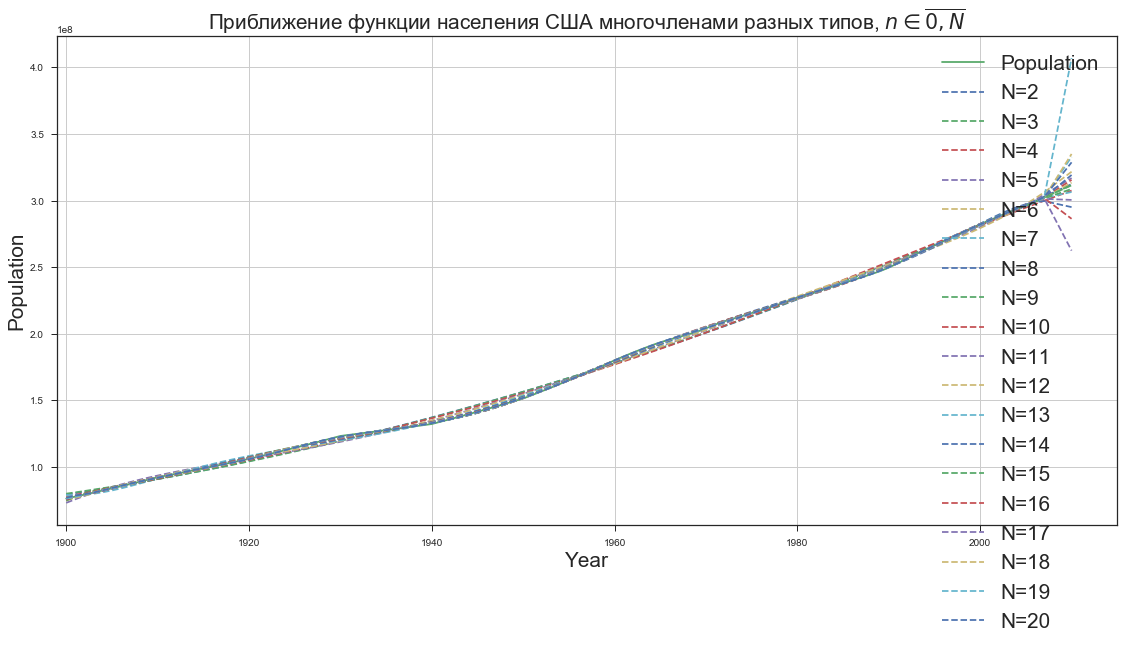

In [16]:
make_plot()
print('Polynom d')
for N in range(2, 21):
    f_appr = approx(N, 'd', plot=True)
    plt.legend(loc='best', fontsize='xx-large')
    print('N: %d, MSE: %f, разница с точным значением в 2010: %f млн' % (N, 
                                        mean_squared_error(population.values, f_appr[:-1])/10**9,
                                        abs(pop_2010 - f_appr[-1:])/10**6))

### Полином e

Polynom e
N: 2, MSE: 9525.037424, разница с точным значением в 2010: 5.838121 млн
N: 3, MSE: 9412.669058, разница с точным значением в 2010: 6.516040 млн
N: 4, MSE: 8530.502512, разница с точным значением в 2010: 8.894908 млн
N: 5, MSE: 6367.413178, разница с точным значением в 2010: 4.393885 млн
N: 6, MSE: 6161.946974, разница с точным значением в 2010: 2.642077 млн
N: 7, MSE: 3903.699241, разница с точным значением в 2010: 6.848315 млн
N: 8, MSE: 3253.942274, разница с точным значением в 2010: 9.153907 млн
N: 9, MSE: 2775.118971, разница с точным значением в 2010: 7.120282 млн
N: 10, MSE: 2736.547998, разница с точным значением в 2010: 6.259711 млн
N: 11, MSE: 18178.248863, разница с точным значением в 2010: 6.121204 млн


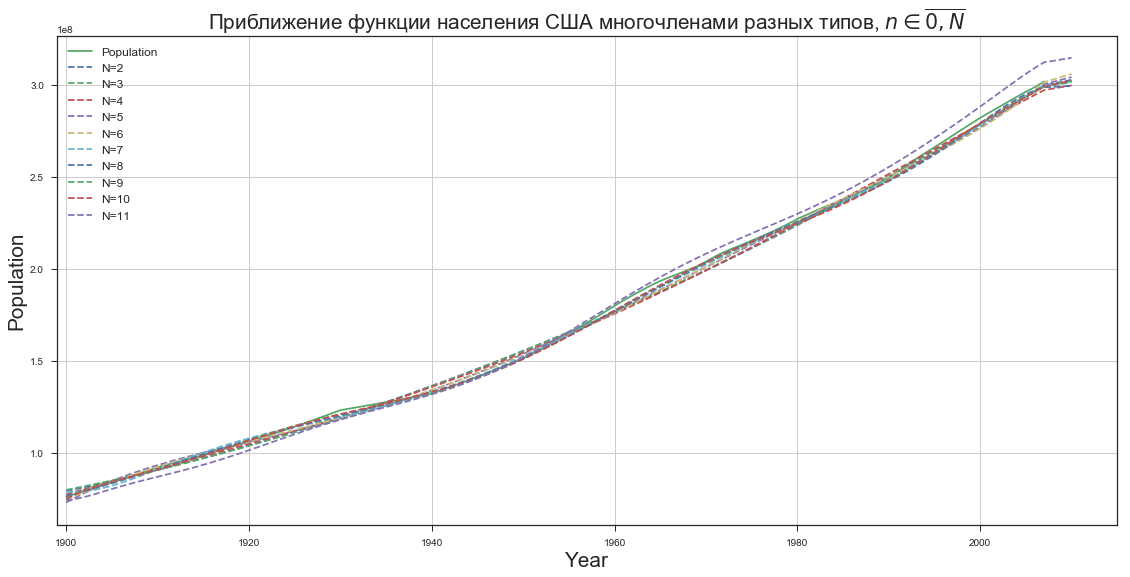

In [17]:
make_plot()
print('Polynom e')
for N in range(2, 12):
    f_appr = approx(N, 'e', plot=True)
    plt.legend(loc='best', fontsize='medium')
    print('N: %d, MSE: %f, разница с точным значением в 2010: %f млн' % (N, 
                                        mean_squared_error(population.values, f_appr[:-1])/10**9,
                                        abs(pop_2010 - f_appr[-1:])/10**6))

### Многочлены Чебышёва

Попробуем еще один тип многочленов — многочлены Чебышёва.

Многочлены 1-ого рода:
$$T_0(x) = 1;~~ T_1(x)=x;~~ T_{n+1}(x) = 2x\cdot T_n(x) - T_{n-1}(x)$$

Многочлены 2-ого рода:
$$U_0(x) = 1;~~ U_1(x)=2x;~~ U_{n+1}(x) = 2x\cdot U_n(x) - U_{n-1}(x)$$

$$f_1(x) = \sum \limits_{k=0}^{N} c_k \cdot T_k(x);~~~~~~~~~~~
f_2(x) = \sum \limits_{k=0}^{N} c_k \cdot U_k(x)$$

$$A_1 = 
\begin{pmatrix}
  T_0(x_1)& T_1(x_1) & \dots & T_N(x_1) \\
  \vdots& \vdots & \ddots & \vdots \\
  T_0(x_m)& T_1(x_m) & \dots & T_N(x_m)
\end{pmatrix};~~~~~~~~~~~~~
A_2 = 
\begin{pmatrix}
  U_0(x_1)& U_1(x_1) & \dots & U_N(x_1) \\
  \vdots& \vdots & \ddots & \vdots \\
  U_0(x_m)& U_1(x_m) & \dots & U_N(x_m)
\end{pmatrix}$$


Т.к. область определения многочленов [-1,1], то необходимо отшкалировать наши x к данному виду. Сделаем это аналогично многочлену e, только будем делать не на отрезке [0,1], а на отрезке [-1,1]

In [18]:
def chebysh(N, ch_type, plot=False, cond=False): # ch_type -- многочлен Чебышева 1 или 2 рода
    A = np.matrix([ch_type(N+1, x) for x in np.linspace(-1, 1, len(years))])
    A_new = np.matrix([ch_type(N+1, x) for x in np.linspace(-1, 1, len(years_2010))])
    
    f = population
    helpA = np.transpose(A) * A
    helpf = np.transpose(A) * np.transpose(np.matrix(f))
    helpInv = np.linalg.inv(helpA) # (A^T*A)^(-1)
    c = np.dot(helpInv, helpf)
    f_appr = np.dot(A_new, c)
    
    if plot == True:
        plt.plot(years_2010, f_appr, '--', label='N='+str(N)) # приближение
        
    if cond:
        print(np.linalg.cond(helpA)) #число обусловленности A^TA
        
    return f_appr

In [19]:
# функции для задания самих многочленов
def T(N, x):
    T = []
    T.append(1)
    T.append(x)
    for i in range(2, N):
        m = 2*x*T[i-1] - T[i-2]
        T.append(m)
    return T

def U(N, x):
    T = []
    T.append(1)
    T.append(2*x)
    for i in range(2, N):
        m = 2*x*T[i-1] - T[i-2]
        T.append(m)
    return T

### Мнгочлены Чебышёва 1-го рода

Подберем сначала промежуток N, в котором ошибка будет наименьшей

In [20]:
print('Chebyshev polynom 1')
for N in range(1, 100, 10):
    f_appr = chebysh(N, T)
    print('N: %d, MSE: %f, разница с точным значением в 2010: %f млн' % (N, 
                                        mean_squared_error(population.values, f_appr[:-1])/10**9,
                                        abs(pop_2010 - f_appr[-1:])/10**6))

Chebyshev polynom 1
N: 1, MSE: 77953.232730, разница с точным значением в 2010: 23.938772 млн
N: 11, MSE: 2569.606209, разница с точным значением в 2010: 7.537408 млн
N: 21, MSE: 2339.773077, разница с точным значением в 2010: 6.764722 млн
N: 31, MSE: 2309.985266, разница с точным значением в 2010: 6.743653 млн
N: 41, MSE: 2293.149226, разница с точным значением в 2010: 6.741689 млн
N: 51, MSE: 2259.490561, разница с точным значением в 2010: 6.741621 млн
N: 61, MSE: 33662.259566, разница с точным значением в 2010: 6.738947 млн
N: 71, MSE: 457028852.626488, разница с точным значением в 2010: 103.420026 млн
N: 81, MSE: 1697271545.361614, разница с точным значением в 2010: 63.609558 млн
N: 91, MSE: 240728356918176224.000000, разница с точным значением в 2010: 914.969912 млн


In [21]:
print('Chebyshev polynom 1')
for N in range(9, 70, 4):
    f_appr = chebysh(N, T)
    print('N: %d, MSE: %f, разница с точным значением в 2010: %f млн' % (N, 
                                        mean_squared_error(population.values, f_appr[:-1])/10**9,
                                        abs(pop_2010 - f_appr[-1:])/10**6))

Chebyshev polynom 1
N: 9, MSE: 2812.418390, разница с точным значением в 2010: 7.169194 млн
N: 13, MSE: 2498.462785, разница с точным значением в 2010: 6.283965 млн
N: 17, MSE: 2404.811370, разница с точным значением в 2010: 7.032924 млн
N: 21, MSE: 2339.773077, разница с точным значением в 2010: 6.764722 млн
N: 25, MSE: 2316.128117, разница с точным значением в 2010: 6.761480 млн
N: 29, MSE: 2312.872546, разница с точным значением в 2010: 6.737590 млн
N: 33, MSE: 2307.938152, разница с точным значением в 2010: 6.740686 млн
N: 37, MSE: 2303.491998, разница с точным значением в 2010: 6.741021 млн
N: 41, MSE: 2293.149226, разница с точным значением в 2010: 6.741689 млн
N: 45, MSE: 2287.978223, разница с точным значением в 2010: 6.741625 млн
N: 49, MSE: 2284.934839, разница с точным значением в 2010: 6.741621 млн
N: 53, MSE: 2640.486496, разница с точным значением в 2010: 6.741620 млн
N: 57, MSE: 2941.452226, разница с точным значением в 2010: 6.741607 млн
N: 61, MSE: 33662.259566, разниц

Chebyshev polynom 1
N: 8, MSE: 3253.221653, разница с точным значением в 2010: 9.152749 млн
N: 9, MSE: 2812.418390, разница с точным значением в 2010: 7.169194 млн
N: 10, MSE: 2786.323997, разница с точным значением в 2010: 6.470517 млн
N: 11, MSE: 2569.606209, разница с точным значением в 2010: 7.537408 млн
N: 12, MSE: 2525.746227, разница с точным значением в 2010: 6.908601 млн
N: 13, MSE: 2498.462785, разница с точным значением в 2010: 6.283965 млн
N: 14, MSE: 2450.811485, разница с точным значением в 2010: 6.573371 млн


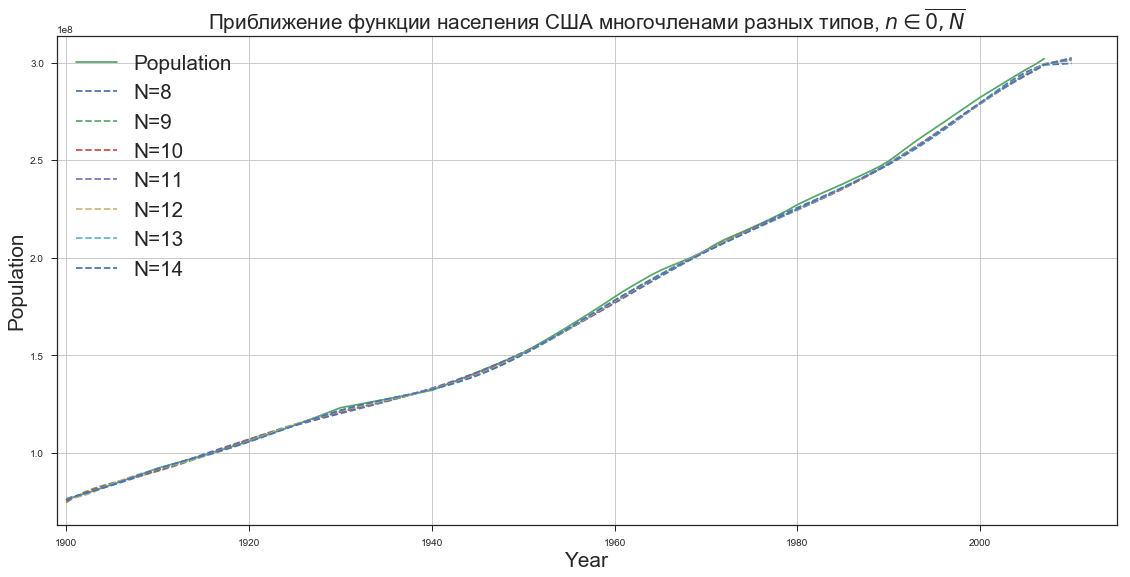

In [22]:
make_plot()
print('Chebyshev polynom 1')
for N in range(8, 15):
    f_appr = chebysh(N, T, plot=True)
    plt.legend(loc='best', fontsize='xx-large')
    print('N: %d, MSE: %f, разница с точным значением в 2010: %f млн' % (N, 
                                        mean_squared_error(population.values, f_appr[:-1])/10**9,
                                        abs(pop_2010 - f_appr[-1:])/10**6))

### Мнгочлены Чебышёва 2-го рода

Проделаем аналогичные действия для 2-го типа

In [23]:
print('Chebyshev polynom 2')
for N in range(1, 100, 10):
    f_appr = chebysh(N, U)
    print('N: %d, MSE: %f, разница с точным значением в 2010: %f млн' % (N, 
                                        mean_squared_error(population.values, f_appr[:-1])/10**9,
                                        abs(pop_2010 - f_appr[-1:])/10**6))

Chebyshev polynom 2
N: 1, MSE: 77953.232730, разница с точным значением в 2010: 23.938772 млн
N: 11, MSE: 2569.606209, разница с точным значением в 2010: 7.537408 млн
N: 21, MSE: 2339.773077, разница с точным значением в 2010: 6.764722 млн
N: 31, MSE: 2309.985266, разница с точным значением в 2010: 6.743653 млн
N: 41, MSE: 2293.149226, разница с точным значением в 2010: 6.741689 млн
N: 51, MSE: 2259.490644, разница с точным значением в 2010: 6.741621 млн
N: 61, MSE: 33656.315026, разница с точным значением в 2010: 6.739916 млн
N: 71, MSE: 4058175499.425481, разница с точным значением в 2010: 1322.369159 млн
N: 81, MSE: 324656792639903.750000, разница с точным значением в 2010: 60601.849837 млн
N: 91, MSE: 3748257668101947.000000, разница с точным значением в 2010: 6913.435657 млн


Chebyshev polynom 2
N: 7, MSE: 3903.686959, разница с точным значением в 2010: 6.848311 млн
N: 8, MSE: 3253.221653, разница с точным значением в 2010: 9.152749 млн
N: 9, MSE: 2812.418390, разница с точным значением в 2010: 7.169194 млн
N: 10, MSE: 2786.323997, разница с точным значением в 2010: 6.470517 млн
N: 11, MSE: 2569.606209, разница с точным значением в 2010: 7.537408 млн
N: 12, MSE: 2525.746227, разница с точным значением в 2010: 6.908601 млн
N: 13, MSE: 2498.462785, разница с точным значением в 2010: 6.283965 млн
N: 14, MSE: 2450.811485, разница с точным значением в 2010: 6.573371 млн
N: 15, MSE: 2440.454689, разница с точным значением в 2010: 6.676410 млн
N: 16, MSE: 2412.644190, разница с точным значением в 2010: 6.900696 млн
N: 17, MSE: 2404.811370, разница с точным значением в 2010: 7.032924 млн
N: 18, MSE: 2369.971950, разница с точным значением в 2010: 6.784597 млн
N: 19, MSE: 2368.642965, разница с точным значением в 2010: 6.634819 млн


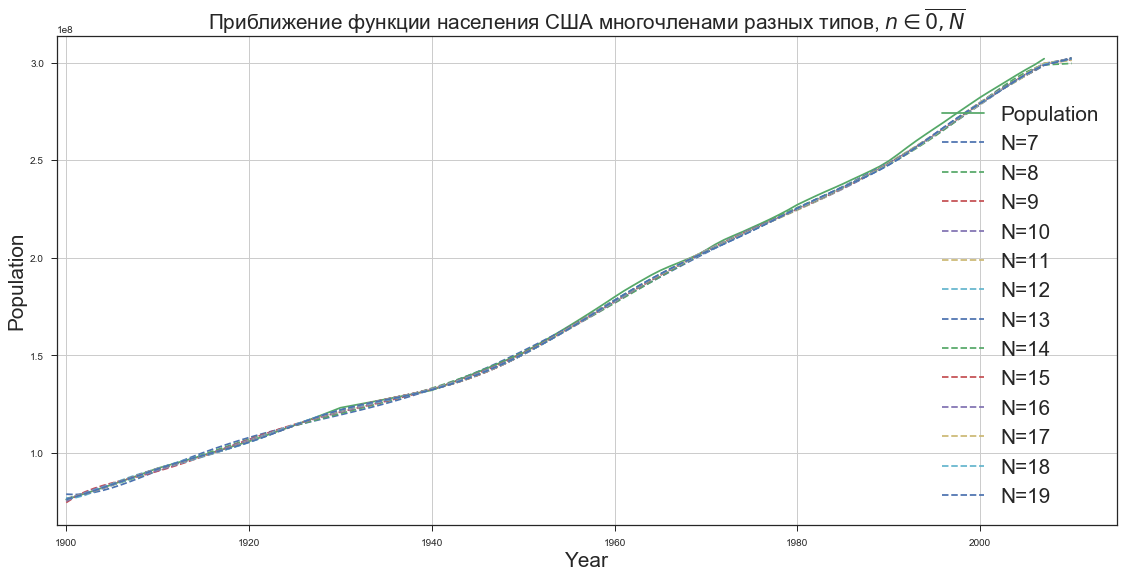

In [24]:
make_plot()
print('Chebyshev polynom 2')
for N in range(7, 20):
    f_appr = chebysh(N, U, plot=True)
    plt.legend(loc='best', fontsize='xx-large')
    print('N: %d, MSE: %f, разница с точным значением в 2010: %f млн' % (N, 
                                        mean_squared_error(population.values, f_appr[:-1])/10**9,
                                        abs(pop_2010 - f_appr[-1:])/10**6))

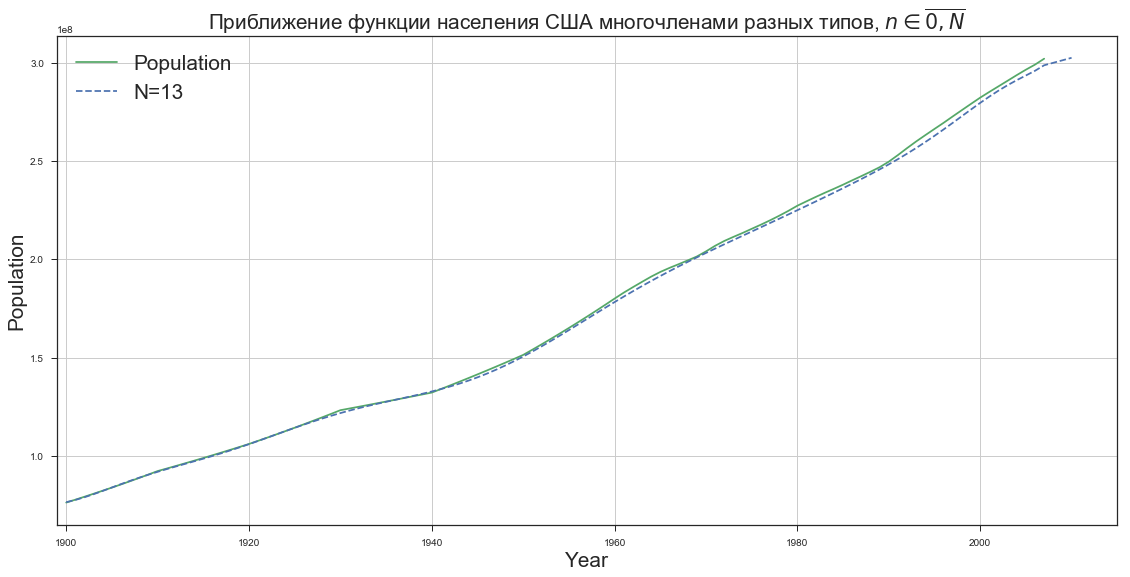

In [34]:
# наилучшее значение для многочлена Чебышева 2 рода
make_plot()
f_appr = chebysh(13, U, plot=True)
plt.legend(loc='best', fontsize='xx-large')

## Итог

Для начала скажем, что рассмотренные модели ортогональны, образуют базис в рассматриваемом пространстве, а значит разложение по ним единственно и эквивалентно. То есть методы эквиваленты.

Как видим, модели a и b в силу своей простоты дают лучшие показания при малых N. 

Модели же d и e могут лучше подстраиваться под данные, поэтому видим при больших N очень маленькую ошибку MSE при соотношении реальных данных и подстроенных, но модель в таком случае переобучается(чересчур подстраивается под данные) и ошибка на предсказании значения в 2010 становится несоизмеримо большой. Лучшее предсказание выдается при N=9 и N=6 (соответственно для d и e) — в этом случае и ошибка MSE тоже сравнительно небольшая. В итоге получаем не самое идеальное подстраивание под данные, но лучшие предсказания. 

Более наглядно эта ситуация видна в случае с многочленами Чебышева, где ошибка MSE становится наименьшей чуть ли не при N=60, но разница в предсказанном значении на 2010 год улетает до небес. Здесь при выборе наилучшей модели тоже придерживались принципа, чтобы ошибка MSE и ошибка в предсказании хоть как-то соотносились (обе достаточно маленькие в сравнении с остальными N)

Сравним наилучшие представления и предсказания для 2010 года

модель a, N: 19, MSE: 7245.605059, разница с точным значением в 2010: 3.594628 млн
модель b, N: 19, MSE: 6415.496031, разница с точным значением в 2010: 1.290168 млн
модель c, N: 19, MSE: 6415.496031, разница с точным значением в 2010: 1.290168 млн
модель d, N: 19, MSE: 567.719739, разница с точным значением в 2010: 0.076044 млн
модель e, N: 19, MSE: 6161.946974, разница с точным значением в 2010: 2.642077 млн
модель chebysh1, N: 19, MSE: 2498.462785, разница с точным значением в 2010: 6.283965 млн
модель chebysh2, N: 19, MSE: 2498.462785, разница с точным значением в 2010: 6.283965 млн


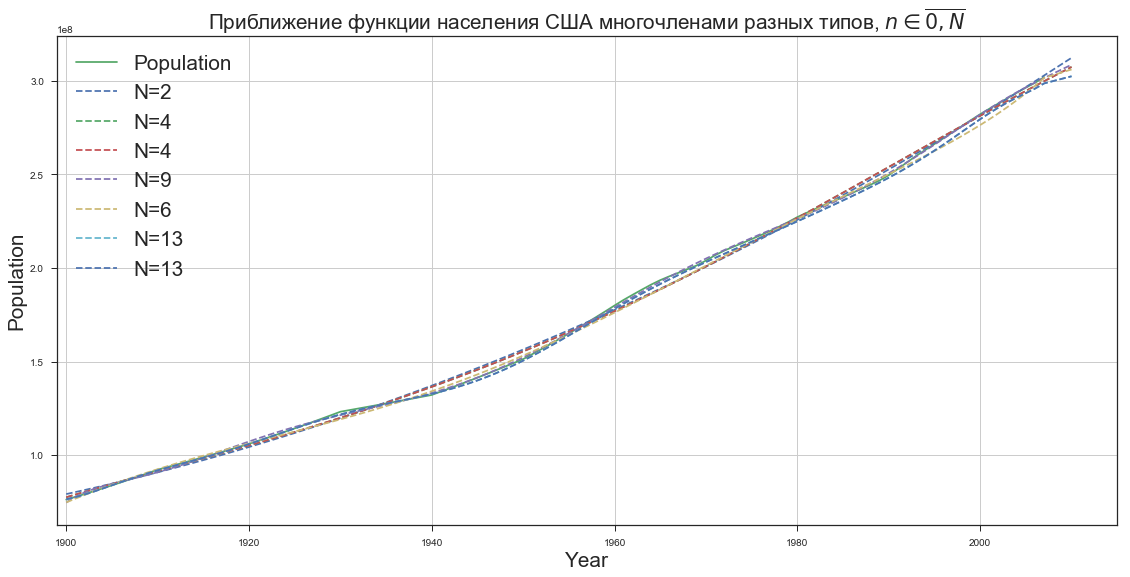

In [26]:
make_plot()
f_a = approx(2, 'a', plot=True)
f_b = approx(4, 'b', plot=True)
f_c = approx(4, 'c', plot=True)
f_d = approx(9, 'd', plot=True)
f_e = approx(6, 'e', plot=True)
f_ch1 = chebysh(13, T, plot=True)
f_ch2 = chebysh(13, U, plot=True)
f = [f_a, f_b, f_c, f_d, f_e, f_ch1, f_ch2]
names = ['a', 'b', 'c', 'd', 'e', 'chebysh1','chebysh2']
i = 0
plt.legend(loc='best', fontsize='xx-large')
for f in f:
    print('модель %s, N: %d, MSE: %f, разница с точным значением в 2010: %f млн' % (names[i], N, 
                                        mean_squared_error(population.values, f[:-1])/10**9,
                                        abs(pop_2010 - f[-1:])/10**6))
    i += 1

Как видно, самое точное предсказание выдала модель d и ошибка MSE у нее вышла наименьшей. Теперь сравним обусловленности этих методов

In [27]:
# 1. Многочлены вида x^n
_ = approx(2, 'a', cond=True)

2.8743395795645288e+20


In [28]:
# 2. Многочлены вида (x-1910)^n
_ = approx(4, 'b', cond=True)

3732463426226962.5


In [29]:
# 3. Многочлены вида (x-1955)^n
_ = approx(4, 'c', cond=True)

28923399302325.23


In [30]:
# 4. Многочлены вида ((x-1955)/52)^n
_ = approx(9, 'd', cond=True)

1182469.0875589696


In [31]:
# 5. Многочлены вида x^n с отнормированными значениями x
_ = approx(6, 'e', cond=True)

430125594.10064316


In [32]:
# 6. Многочлены Чебышева 1 рода
_ = chebysh(13, T, cond=True)

8.861734447877964


In [33]:
# 7. Многочлены Чебышева 2 рода
_ = chebysh(13, U, cond=True)

15.659400898747142


Хоть и предсказания через многочлены Чебышева вышли не такими точными, как у остальных моделей, данные многочлены отличаются хорошей обусловленностью. Среди остальных моделей число обусловленности наименьшее у модели d, что говорит о большей точности моделей d и многочленов Чебышева